## Setup

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qutip.qip.operations import *
from qutip.qip.circuit import *
from qutip.qip.operations import s_gate
import sys
sys.path.append('../SimulationCode/')
from BlindGatesSimulation import *
from fiber_network import FiberNetwork
from SiVnodes import SiV
from SiVgates import *
from Plots import *
import pandas as pd
import matplotlib as mpl

In [2]:
# colors for plots
c1 = '#F15F57'
c2 = '#F6851F'
c3 = '#FDB913'
c4 = '#743062'
c5 = '#C87EB5'
c6 = '#4CC0B3'
c7 = '#1C9AAA'

#### Define SiVs 

In [3]:
# Create SiVs:

#Server A, G12
siv_a = SiV(kappa_in= (74.9 - 54.5)*(10**3), kappa_w= (54.5)*(10**3), g=5.6*(10**3), wCav = (0)*(10**3), 
             wSiv = -(479.8 -639.6)*(10**3), dwEl = 0.5*(10**3)) # G12
#Server B, B16
siv_b = SiV(kappa_in= (43.5 - 26.0)*(10**3), kappa_w= (26.0)*(10**3), g=8.5*(10**3), wCav = (0)*(10**3), 
             wSiv = -(804.9 -657.6)*(10**3), dwEl = -0.5*(10**3)) # B16

## Setup single Node experiments in B16

In [4]:
# Create Networks:
b16_network = FiberNetwork(siv_b) # this device is now in B16 fridge

# Create Simulation:
sim = BlindComputing(b16_network)

In [5]:
# Setup efficiencies
fudge = 1

b16_network.fibercoupling_eff = 0.6*fudge
b16_network.tdi_eff = 0.35*0.3
b16_network.snspd_eff = 0.9
b16_network.detection_eff
b16_network.detection_eff_reset()

print('Detection efficientvy is = ', b16_network.detection_eff)

Detection efficientvy is =  0.0567


#### MW gates

In [6]:
# gate fidelities

b16_mwfid = 0.99
g12_mwfid = 1

#### Move the SiV to the desired contrast point

In [7]:
b16_contrast = 25 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

new contrast 27.979731852612378
B16 contrast is set to =  27.979731852612378


In [6]:
el_initial_xp = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_xm = qt.ket2dm((qt.basis(2,0)- qt.basis(2,1)).unit())
el_initial_zp = qt.ket2dm(qt.basis(2, 0))
el_initial_zm = qt.ket2dm(qt.basis(2, 1))
el_initial_ym = qt.ket2dm(qt.basis(2, 0)- 1j* qt.basis(2, 1)).unit()
el_initial_yp = qt.ket2dm(qt.basis(2, 0)+ 1j* qt.basis(2, 1)).unit()


## B16 single qubit rotations

In [113]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': - 0.1, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.05

In [109]:
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

In [ ]:
cluster_state_length = 1
n_rounds = 10000

rates_apd1_apd2 = np.empty((0, 2), dtype=float)
rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)
nxnynz_cl_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
nxnynz_s_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
for j in range(len(phi1)):
    rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
    rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
    rho_click = np.empty((0, 1), dtype=int)
    phi1e = phi1[j]
    print("Phi angle = ", phi1e)
    nxnynz_cl_array =  np.empty((0, 3), dtype=float)
    nxnynz_s_array =  np.empty((0, 3), dtype=float)
    for i in range(n_rounds): 
        if i%100 == 0:
            print(i)
        rho_init_xp = sim2.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
        rho_n_item_s = rho_init_xp[0]
        rho_n_item_cl = (qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))
        rho_n_array_s = np.vstack([rho_n_array_s, [rho_n_item_s]])
        rho_n_array_cl = np.vstack([rho_n_array_cl, [rho_n_item_cl]])
        nxnynz_cl = calculate_bloch_components(rho_n_item_cl)
        nxnynz_s = calculate_bloch_components(rho_n_item_s)
        nxnynz_cl_array =  np.vstack([nxnynz_cl_array, [nxnynz_cl]])
        nxnynz_s_array =  np.vstack([nxnynz_s_array, [nxnynz_s]])
    nxnynz_cl_phi_array =  np.vstack([nxnynz_cl_phi_array, [nxnynz_cl_array]])
    nxnynz_s_phi_array =  np.vstack([nxnynz_s_phi_array, [nxnynz_s_array]])
    mean_cl_nxnynz = np.mean(nxnynz_cl_array, axis =0)
    std_cl_nxnynz = np.std(nxnynz_cl_array, axis =0)/np.sqrt(n_rounds)
    mean_s_nxnynz = np.mean(nxnynz_s_array, axis =0)
    std_s_nxnynz = np.std(nxnynz_s_array, axis =0)/np.sqrt(n_rounds)
    print(mean_cl_nxnynz, std_cl_nxnynz)
    print(mean_s_nxnynz, std_s_nxnynz)
    rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])

    rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
    rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])

In [118]:
fid_err_phi =  np.empty((0, 2), dtype=float)
fid_ave_phi =  np.empty((0, 2), dtype=float)
for j in range(len(phi1)):
    U = rz(phi1[j])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_n =  np.empty((0, 2), dtype=float)
    for k in range(n_rounds):
        fid = (qt.fidelity(qt.Qobj(rho_phi_n_array_cl[j][k]), el_rho_final_ideal))**2
        fid_n = np.append(fid_n, fid)
    fid_ave = np.mean(fid_n, axis = 0)
    # this is only the variability of the measurement
    fid_ave_std = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))
    fid_ave_phi = np.append(fid_ave_phi, fid_ave)
    fid_err_phi = np.append(fid_err_phi, fid_ave_std)

In [136]:
print(np.mean(nxnynz_cl_phi_array, axis = 1))
print(np.std(nxnynz_cl_phi_array, axis = 1)/np.sqrt(n_rounds))
print(np.mean(nxnynz_s_phi_array, axis = 1))
print(np.std(nxnynz_s_phi_array, axis = 1)/np.sqrt(n_rounds))

[[ 0.91115257 -0.09011496 -0.0069548 ]
 [ 0.71044618  0.56911975 -0.01335258]
 [ 0.09455779  0.89694037 -0.00762512]
 [-0.58053426  0.69644991 -0.00639887]]
[[0.00095105 0.0003485  0.00325048]
 [0.00148431 0.00166445 0.00276787]
 [0.00318744 0.00040197 0.0019758 ]
 [0.00204214 0.00163996 0.00254271]]
[[ 0.3057609   0.00047353 -0.0069548 ]
 [ 0.31610002  0.00475654 -0.01335258]
 [ 0.30978769  0.0088627  -0.00762512]
 [ 0.315204   -0.00804258 -0.00639887]]
[[0.00863571 0.00096618 0.00325048]
 [0.00653335 0.00592941 0.00276787]
 [0.00120707 0.00897797 0.0019758 ]
 [0.00528554 0.00715453 0.00254271]]


In [120]:
fid = np.mean(fid_ave_phi, axis = 0)
fiderr = np.sqrt(np.sum(fid_err_phi**2)/len(fid_err_phi))
print('Fidelity over phi = ', fid, "+-",  fiderr)

Fidelity over phi =  0.9519808652203994 +- 0.00034877246933622664


#### Blindness

In [121]:
rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

mean_nxnynz = np.mean(nxnynz_s_phi_array, axis =1)
std_nxnynz = np.std(nxnynz_s_phi_array, axis =1)/np.sqrt(n_rounds)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2, axis = 1))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2, axis = 1)))]
eigen_phis_std = np.array([eigenvalue_uncertainty(mean_nxnynz[i], std_nxnynz[i]) for i in range(len(mean_nxnynz))])

rho_ave_phi_array = np.mean(rho_phi_n_array_s, axis = 1)
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
nxnynz_tot = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
nxnynz_tot_std = np.sqrt(np.sum(eigen_phis_std**2))/len(eigen_phis_std)

# std of variability of eigenvalues of rho tot
std_eigen_tot = eigenvalue_uncertainty(nxnynz_tot.ravel(), [nxnynz_tot_std,nxnynz_tot_std,nxnynz_tot_std])
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])
rho_tot_sigma_lambdas = (std_eigen_tot, std_eigen_tot)
rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
rho_lambdas = list(zip(eigen_phis[0], eigen_phis[1]))
rho_sigma_lambdas =  [(value, value) for value in eigen_phis_std]

hv_std = holevo_bound_uncertainty(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)


Holevo bound is =  3.4100408453419107e-05 0.000983889713131907


## B16 universal single qubit rotations

#### Identity

In [395]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.3
phi_array  = [0, 0, 0]

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())

cluster_state_length = 3


In [396]:
n_rounds = 30 # estimate for 6 hrs of run
el_rho_final_ideal = el_initial_yp

rho_n_array_cl_id = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_id = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_id =  np.empty((0, 3), dtype=float)
nxnynz_s_array_id =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = single_qubit_universal_blind_gate_with_feedback(el_initial_yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_id = np.vstack([rho_n_array_s_id, [rho_s]])
    rho_n_array_cl_id = np.vstack([rho_n_array_cl_id, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_id = np.vstack([nxnynz_cl_array_id, [nxnynz_cl]])
    nxnynz_s_array_id = np.vstack([nxnynz_s_array_id, [nxnynz_s]])
nxnynz_tot_cl_id = np.mean(nxnynz_cl_array_id, axis = 0)
nxnynz_tot_s_id = np.mean(nxnynz_s_array_id, axis = 0)
nxnynz_tot_std_cl_id = np.std(nxnynz_cl_array_id, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_id = np.std(nxnynz_s_array_id, axis = 0)/np.sqrt(n_rounds)

fid_ave_id = np.mean(fid_n, axis = 0)
fid_ave_std_id = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_id)
print(nxnynz_tot_std_cl_id)

print(nxnynz_tot_s_id)
print(nxnynz_tot_std_s_id)



print("Fidelity of a universal Identity gate = ", fid_ave_id, "+-", fid_ave_std_id)


[-0.08693934  0.16437464  0.01678555]
[0.06534826 0.08418688 0.0592319 ]
[-0.24562242  0.46754125 -0.00220998]
[0.05011318 0.02648718 0.05930976]
Fidelity of a universal Identity gate =  0.7337706292150785 +- 0.013243592119313394


##### FIdelity of Identity

In [397]:
U_transform_ztoy = qt.Qobj([[1, 1j], [1j, 1]]) / (2 ** 0.5)
print(U_transform_ztoy*el_initial_yp*U_transform_ztoy.dag())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]


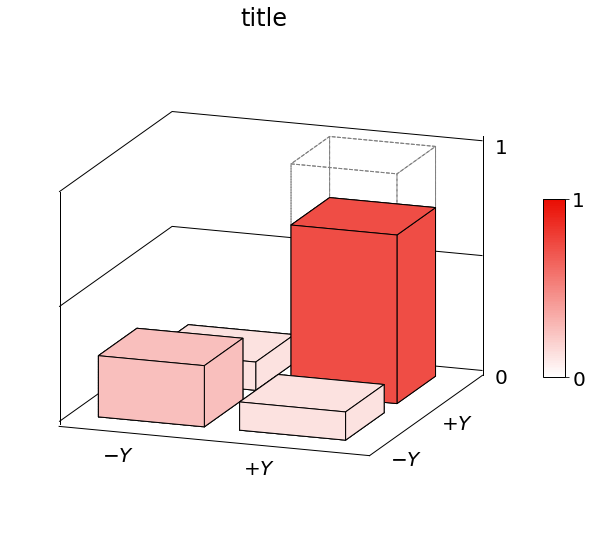

In [398]:
rho = np.mean(rho_n_array_cl_id, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "title", "filename", 'Blues')

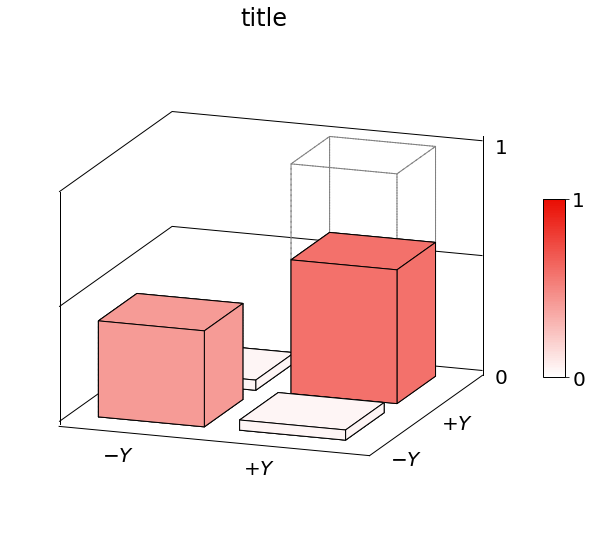

In [399]:
rho = np.mean(rho_n_array_s_id, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "title", "filename", 'Blues')

#### Hadamart

In [400]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.3
phi_array  = [np.pi/2, np.pi/2, np.pi/2]

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())

cluster_state_length = 3


In [401]:
n_rounds = 30 # estimate for 6 hrs of run
el_rho_final_ideal = el_initial_ym


rho_n_array_cl_had = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_had = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_had =  np.empty((0, 3), dtype=float)
nxnynz_s_array_had =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = single_qubit_universal_blind_gate_with_feedback(el_initial_yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_had = np.vstack([rho_n_array_s_had, [rho_s]])
    rho_n_array_cl_had = np.vstack([rho_n_array_cl_had, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_had = np.vstack([nxnynz_cl_array_had, [nxnynz_cl]])
    nxnynz_s_array_had = np.vstack([nxnynz_s_array_had, [nxnynz_s]])
nxnynz_tot_cl_had = np.mean(nxnynz_cl_array_had, axis = 0)
nxnynz_tot_s_had = np.mean(nxnynz_s_array_had, axis = 0)
nxnynz_tot_std_cl_had = np.std(nxnynz_cl_array_had, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_had = np.std(nxnynz_s_array_had, axis = 0)/np.sqrt(n_rounds)

fid_ave_had = np.mean(fid_n, axis = 0)
fid_ave_std_had = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_had)
print(nxnynz_tot_std_cl_had)

print(nxnynz_tot_s_had)
print(nxnynz_tot_std_s_had)

print("Fidelity of a universal Identity gate = ", fid_ave_had, "+-", fid_ave_std_had)


[-0.05406417  0.05728237 -0.01482528]
[0.06538386 0.09077105 0.08186572]
[ 0.04034993 -0.4607686  -0.23402041]
[0.06571308 0.03566281 0.06988422]
Fidelity of a universal Identity gate =  0.7303843067091331 +- 0.017831407308288045


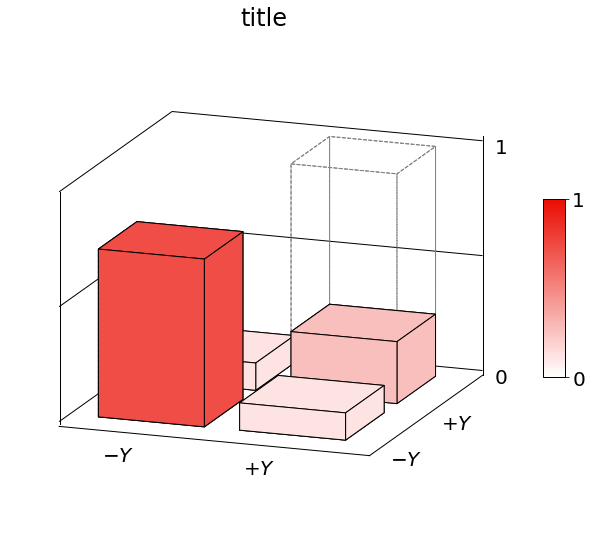

In [402]:
rho = np.mean(rho_n_array_cl_had, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "title", "filename", 'Blues')

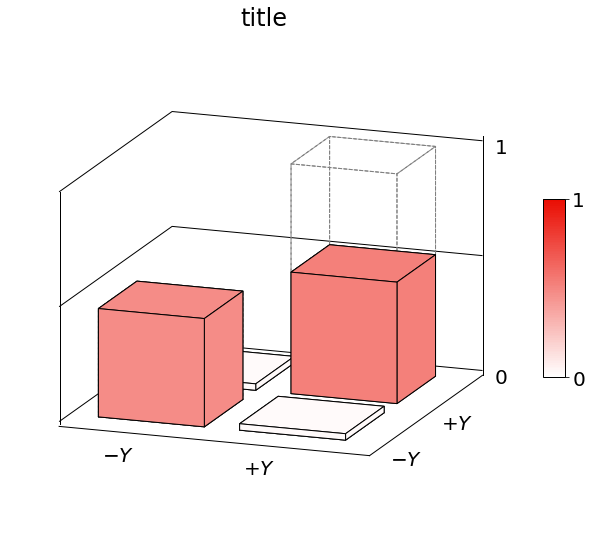

In [403]:
rho = np.mean(rho_n_array_s_had, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "title", "filename", 'Blues')

#### T sqrt(X) T

In [404]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.3
phi_array  = [np.pi/4, np.pi/2, np.pi/4]

cluster_state_length = 3


In [405]:
TsqXT = rz(np.pi/4)*rx(np.pi/2)*rz(np.pi/4)
el_rho_final_ideal = TsqXT*el_initial_yp*TsqXT.dag()
print(el_rho_final_ideal)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.85355339+0.j   -0.25      +0.25j]
 [-0.25      -0.25j  0.14644661+0.j  ]]


In [406]:
n_rounds = 30 # estimate for 6 hrs of run

rho_n_array_cl_txt = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_txt = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_txt =  np.empty((0, 3), dtype=float)
nxnynz_s_array_txt =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = single_qubit_universal_blind_gate_with_feedback(el_initial_yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_txt = np.vstack([rho_n_array_s_txt, [rho_s]])
    rho_n_array_cl_txt = np.vstack([rho_n_array_cl_txt, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_txt = np.vstack([nxnynz_cl_array_txt, [nxnynz_cl]])
    nxnynz_s_array_txt = np.vstack([nxnynz_s_array_txt, [nxnynz_s]])
nxnynz_tot_cl_txt = np.mean(nxnynz_cl_array_txt, axis = 0)
nxnynz_tot_s_txt = np.mean(nxnynz_s_array_txt, axis = 0)
nxnynz_tot_std_cl_txt = np.std(nxnynz_cl_array_txt, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_txt = np.std(nxnynz_s_array_txt, axis = 0)/np.sqrt(n_rounds)

fid_ave_txt = np.mean(fid_n, axis = 0)
fid_ave_std_txt = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_txt)
print(nxnynz_tot_std_cl_txt)

print(nxnynz_tot_s_txt)
print(nxnynz_tot_std_s_txt)

print("Fidelity of a universal Identity gate = ", fid_ave_txt, "+-", fid_ave_std_txt)


[-0.11094597  0.08819732  0.08882447]
[0.07514703 0.08342183 0.07435154]
[-0.26740405 -0.4252258   0.14924287]
[0.06061253 0.03451464 0.07105418]
Fidelity of a universal Identity gate =  0.7259227891763015 +- 0.027475109476144313


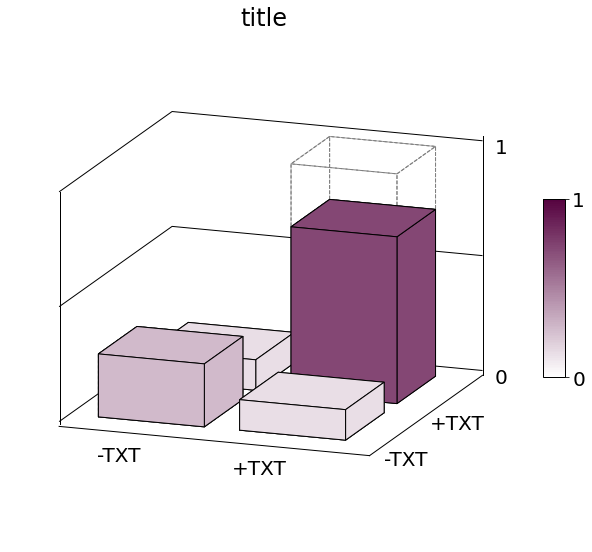

In [407]:
rho = np.mean(rho_n_array_cl_txt, axis = 0)
# to TXTy basis 
U_txt = U_transform_ztoy*TsqXT.dag()
rho_y = U_txt*rho*U_txt.dag()
plot_from_rho_magic(rho_y, "title", "filename", 'Blues')

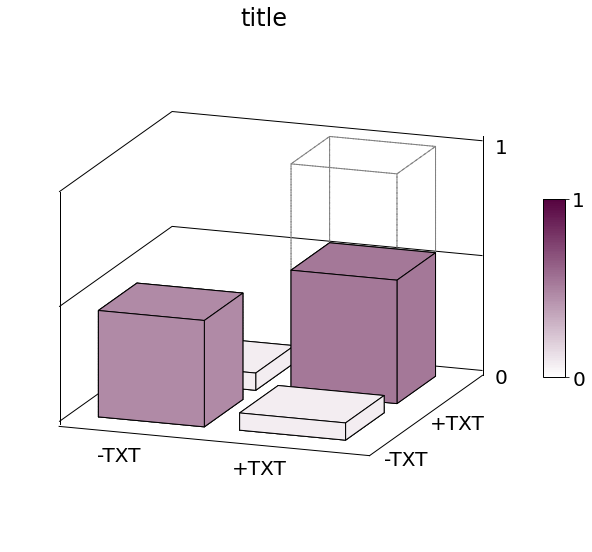

In [408]:
rho = np.mean(rho_n_array_s_txt, axis = 0)
# from Z to Y basis
rho_y = U_txt*rho*U_txt.dag()
plot_from_rho_magic(rho_y, "title", "filename", 'Blues')

#### Blindness for the universal single qubit gate

In [423]:
rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

mean_nxnynz = np.concatenate(([nxnynz_tot_s_id], [nxnynz_tot_s_had], [nxnynz_tot_s_txt]), axis=0)
std_nxnynz = np.concatenate(([nxnynz_tot_std_s_id], [nxnynz_tot_std_s_had], [nxnynz_tot_std_s_txt]), axis=0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2, axis = 1))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2, axis = 1)))]
eigen_phis_std = np.array([eigenvalue_uncertainty(mean_nxnynz[i], std_nxnynz[i]) for i in range(len(mean_nxnynz))])

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_id, axis = 0),np.mean(rho_n_array_s_had, axis = 0), np.mean(rho_n_array_s_txt, axis = 0)])
rho_ave_phi_arrayrho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
nxnynz_tot = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
nxnynz_tot_std = np.sqrt(np.sum(eigen_phis_std**2))/len(eigen_phis_std)

# std of variability of eigenvalues of rho tot
std_eigen_tot = eigenvalue_uncertainty(nxnynz_tot.ravel(), [nxnynz_tot_std,nxnynz_tot_std,nxnynz_tot_std])
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = (std_eigen_tot, std_eigen_tot)
rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
rho_lambdas = list(zip(eigen_phis[0], eigen_phis[1]))
print(rho_lambdas)
rho_sigma_lambdas =  [(value, value) for value in eigen_phis_std]
hv_std = holevo_bound_uncertainty(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)


TypeError: Incompatible Qobj shapes

## B16 Intranode two-qubit gate 

In [313]:
b16_mwfid_unitary = 1
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'tdinoise': 0, #np.pi/25, #'real'
                'mw': 'perfect', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.0003
eln_initial = qt.tensor(el_initial_xp, el_initial_xp)

In [360]:
SS = qt.tensor(s_gate(), s_gate())
CZ_gate = cphase(np.pi, N=2, control=0, target=1)
Ent_gate = SS*CZ_gate
el_rho_final_ideal_0 = eln_initial # identity operation
el_rho_final_ideal_pi2 =Ent_gate*eln_initial*Ent_gate.dag() # S1S2CZ
el_rho_final_ideal_pi4 =qt.ket2dm(qt.tensor((qt.basis(2,0) + np.exp(-1j*((np.pi/4)))*qt.basis(2,1)).unit(), qt.basis(2,1)) \
          + np.exp(-1j*(np.pi/4))*qt.tensor((qt.basis(2,0) + np.exp(1j*(np.pi/4))*qt.basis(2,1)).unit(), qt.basis(2,0))).unit()
el_rho_final_ideal_3pi4 =qt.ket2dm(qt.tensor((qt.basis(2,0) + np.exp(-1j*((3*np.pi/4)))*qt.basis(2,1)).unit(), qt.basis(2,1)) \
          + np.exp(-1j*(3*np.pi/4))*qt.tensor((qt.basis(2,0) + np.exp(1j*(3*np.pi/4))*qt.basis(2,1)).unit(), qt.basis(2,0))).unit()

##### Angle = 0

In [415]:
n_rounds = 40
rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
fid_n_0 =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim2.two_qubit_intranode_blind_gate(eln_initial, imperfections, 0, mu)
    rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_output[0]]])
    rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_0))**2
    fid_n_0 = np.append(fid_n_0, fid)
    
fid_ave_0 = np.mean(fid_n_0, axis = 0)
fid_ave_std_0 = np.std(fid_n_0, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_0, "+-", fid_ave_std_0)

Fidelity of an intranode gate =  0.8714260804488176 +- 0.006322338927379357


##### Angle = pi4

In [416]:
n_rounds = 40
rho_n_array_cl_pi4 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_pi4 = np.empty((0, 4, 4), dtype=complex)
fid_n_pi4=  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = two_qubit_intranode_blind_gate(eln_initial, imperfections, np.pi/4, mu)
    rho_n_array_s_pi4 = np.vstack([rho_n_array_s_pi4, [rho_output[0]]])
    rho_n_array_cl_pi4 = np.vstack([rho_n_array_cl_pi4, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_pi4))**2
    fid_n_pi4 = np.append(fid_n_pi4, fid)
    
fid_ave_pi4 = np.mean(fid_n_pi4, axis = 0)
fid_ave_std_pi4 = np.std(fid_n_pi4, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_pi4, "+-", fid_ave_std_pi4)

Fidelity of an intranode gate =  0.8760999768860656 +- 0.009522583235357882


##### Angle = pi/2

In [417]:
n_rounds = 40
rho_n_array_cl_pi2 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_pi2 = np.empty((0, 4, 4), dtype=complex)
fid_n_pi2=  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = two_qubit_intranode_blind_gate(eln_initial, imperfections, np.pi/2, mu)
    rho_n_array_s_pi2 = np.vstack([rho_n_array_s_pi2, [rho_output[0]]])
    rho_n_array_cl_pi2 = np.vstack([rho_n_array_cl_pi2, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_pi2))**2
    fid_n_pi2 = np.append(fid_n_pi2, fid)
    
fid_ave_pi2 = np.mean(fid_n_pi2, axis = 0)
fid_ave_std_pi2 = np.std(fid_n_pi2, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_pi2, "+-", fid_ave_std_pi2)

Fidelity of an intranode gate =  0.8609979551070841 +- 0.007040677513427944


##### Angle = 3pi/4

In [418]:
rho_n_array_cl_3pi4 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_3pi4 = np.empty((0, 4, 4), dtype=complex)
fid_n_3pi4=  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = two_qubit_intranode_blind_gate(eln_initial, imperfections, 3*np.pi/4, mu)
    rho_n_array_s_3pi4 = np.vstack([rho_n_array_s_3pi4, [rho_output[0]]])
    rho_n_array_cl_3pi4 = np.vstack([rho_n_array_cl_3pi4, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_3pi4))**2
    fid_n_3pi4 = np.append(fid_n_3pi4, fid)
    
fid_ave_3pi4 = np.mean(fid_n_3pi4, axis = 0)
fid_ave_std_3pi4 = np.std(fid_n_3pi4, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_3pi4, "+-", fid_ave_std_3pi4)

Fidelity of an intranode gate =  0.8669312285604327 +- 0.0061679709586487325


#### Blindness of Intranode gate

In [422]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_0, axis = 0),np.mean(rho_n_array_s_pi4, axis = 0), np.mean(rho_n_array_s_pi2, axis = 0), np.mean(rho_n_array_s_3pi4, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_0 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_0]
eigen_phis_pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi4]
eigen_phis_pi2 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi2]
eigen_phis_3pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_3pi4]

factor = np.sqrt(len(eigen_phis_0))
eigen_phis = np.array([np.mean(eigen_phis_0, axis = 0),np.mean(eigen_phis_pi4, axis = 0),np.mean(eigen_phis_pi2, axis = 0),np.mean(eigen_phis_3pi4, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_0, axis = 0)/factor,np.std(eigen_phis_pi4, axis = 0)/factor,np.std(eigen_phis_pi2, axis = 0)/factor,np.std(eigen_phis_3pi4, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.std(eigen_tot)/factor
hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

# rho_tot_sigma_lambdas = (std_eigen_tot, std_eigen_tot)
rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
rho_lambdas = list(zip(eigen_phis[0], eigen_phis[1]))
rho_sigma_lambdas =  [(value, value) for value in eigen_phis_std]
hv_std = holevo_bound_uncertainty(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std[0])

Holevo bound is =  0.004362755931894391 0.14610755128548414


## Setup Two-Node experiments in B16-G12

In [4]:
# Create Networks:
g12_b16_network = FiberNetwork(siv_a, siv_b) # this device is now in B16 fridge

# Create Simulation:
sim2 = BlindComputing(g12_b16_network)

In [5]:
# Setup efficiencies
fudge = 1

g12_b16_network.fibercoupling_eff = 0.6*fudge
g12_b16_network.tdi_eff = 0.35*0.3
g12_b16_network.snspd_eff = 0.9
g12_b16_network.detection_eff
g12_b16_network.detection_eff_reset()
g12_b16_network.link_efficiency = (g12_b16_network.fibercoupling_eff**2)*0.05*0.64

print('Detection efficientvy is = ', g12_b16_network.detection_eff)
print('Link efficientvy is = ', g12_b16_network.link_efficiency)

Detection efficientvy is =  0.0567
Link efficientvy is =  0.011519999999999999


#### MW gates

In [7]:
# gate fidelities
b16_mwfid = 1
g12_mwfid = 1

#### Move the SiV to the desired contrast point

In [8]:
b16_contrast = 25 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

siv_a.set_contrast(g12_contrast)
actual_contrast_g12 = siv_a.get_best_contrast()
print("G12 contrast is set to = ", actual_contrast_g12)

new contrast 27.979731852612378
B16 contrast is set to =  27.979731852612378
new contrast 22.984605715760697
G12 contrast is set to =  22.984605715760697


## B16-G12 Internode two-qubit gate

In [487]:
b16_mwfid_unitary = 1
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'tdinoise': 0, #np.pi/25, #'real'
                'mw': 'perfect', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.0003
Entange = 0 # choices are {0, 1}
# e1e2n2
een_initial = qt.tensor(el_initial_xp, el_initial_xp, el_initial_xp)

In [918]:
def qudit_collapse(rho, timebine):
    # for testing only: measure the correlatikos of spin state with each time bin
    Pj_1000 = qt.composite(Id2, Id2, qt.ket2dm(qt.fock(N, 1)), qt.ket2dm(qt.fock(N, 0)), qt.ket2dm(qt.fock(N, 0)), qt.ket2dm(qt.fock(N, 0)))
    Pj_0100 = qt.composite(Id2, Id2, qt.ket2dm(qt.fock(N, 0)), qt.ket2dm(qt.fock(N, 1)), qt.ket2dm(qt.fock(N, 0)), qt.ket2dm(qt.fock(N, 0)))        
    Pj_0010 = qt.composite(Id2, Id2, qt.ket2dm(qt.fock(N, 0)), qt.ket2dm(qt.fock(N, 0)), qt.ket2dm(qt.fock(N, 1)), qt.ket2dm(qt.fock(N, 0)))
    Pj_0001 = qt.composite(Id2, Id2,qt.ket2dm(qt.fock(N, 0)), qt.ket2dm(qt.fock(N, 0)), qt.ket2dm(qt.fock(N, 0)), qt.ket2dm(qt.fock(N, 1)))        
    # probability of each bin firing
    brate_bin_1 = (Pj_1000*rho*Pj_1000.dag()).tr()
    brate_bin_2 = (Pj_0100*rho*Pj_0100.dag()).tr()
    brate_bin_3 = (Pj_0010*rho*Pj_0010.dag()).tr()
    brate_bin_4 = (Pj_0001*rho*Pj_0001.dag()).tr()    
  
    #Final density matrix of the electron state
    rho_final_bin_1 = ((Pj_1000*rho*Pj_1000.dag())/brate_bin_1).ptrace([0, 1]) # spin state left over after bin 1 firing
    rho_final_bin_2 = ((Pj_0100*rho*Pj_0100.dag())/brate_bin_2).ptrace([0, 1]) # spin state left over after bin 2 firing
    rho_final_bin_3 = ((Pj_0010*rho*Pj_0010.dag())/brate_bin_3).ptrace([0, 1]) # spin state left over after bin 3 firing
    rho_final_bin_4 = ((Pj_0001*rho*Pj_0001.dag())/brate_bin_4).ptrace([0, 1]) # spin state left over after bin 4 firing
    
    if timebine == 0:
        rho = rho_final_bin_1
    elif timebine == 1:
        rho = rho_final_bin_2
    elif timebine == 2:
        rho = rho_final_bin_3
    elif timebine == 3:
        rho = rho_final_bin_4
    return rho



In [934]:
Entange = 1
rho_final = two_qubit_internode_blind_gate(een_initial, imperfections, Entange, mu)
print(rho_final[1], rho_final[2])
oper = qt.tensor(Id2, ry(np.pi/2))
print(oper*rho_final[2]*oper.dag())

Initial number of photons per timebin and qubit = 1.7288642661304855e-06
[0, 1, 1]
0 1 1
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25+0.j    0.25+0.j    0.  +0.25j  0.  -0.25j]
 [ 0.25+0.j    0.25+0.j    0.  +0.25j  0.  -0.25j]
 [ 0.  -0.25j  0.  -0.25j  0.25+0.j   -0.25+0.j  ]
 [ 0.  +0.25j  0.  +0.25j -0.25+0.j    0.25+0.j  ]] Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25  0.25  0.25 -0.25]
 [ 0.25  0.25  0.25 -0.25]
 [ 0.25  0.25  0.25 -0.25]
 [-0.25 -0.25 -0.25  0.25]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]


In [932]:
#ideal
print(een_initial.ptrace([0, 2]))
print(qt.ket2dm(qt.tensor(qt.basis(2, 1), qt.basis(2, 0)) + qt.tensor(qt.basis(2, 0), qt.basis(2, 1))).unit())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]


In [529]:
def el2_qudit_gate_QUBE(rho, gates, cav_refl, imperfections_contrast, mu):
    """ Electron 2 QUDIT Entaglement """

    print('Initial number of photons per timebin and qubit =', (Noperator*rho.ptrace([3])).tr() + (Noperator*rho.ptrace([4])).tr() + (Noperator*rho.ptrace([5])).tr() + (Noperator*rho.ptrace([6])).tr())
    
    bs_QUBE = siv_beamsplitter_el2_qudit_QUBE(cav_refl, imperfections_contrast)

    pi_plus_y = gates['pi']
    pi_plus_x = rz(-np.pi/2)*gates['pi']*rz(-np.pi/2).dag()

    pi_minus_y = qt.sigmaz()*gates['pi']*qt.sigmaz()
    # do a - pi y gate on 2nd the electron
    pi_minus_oper = qt.tensor(Id2, pi_minus_y, Id2, IdN, IdN, IdN, IdN)
    # do a +pi y gate on 2nd the electron
    pi_plus_oper = qt.tensor(Id2, pi_plus_x, Id2, IdN, IdN, IdN, IdN)

    # reflect bin 0
    rho_1 = bs_QUBE[0]*(qt.tensor(rho, qt.fock_dm(N, 0)))*bs_QUBE[0].dag()
    rho_2 = (bs_QUBE[1]*(qt.tensor(rho_1, qt.fock_dm(N, 0)))*bs_QUBE[1].dag()).ptrace([0, 1, 2, 4, 5, 6, 7])
    


    # +pi around y
    rho_3 = pi_plus_oper*rho_2*pi_plus_oper.dag()
    # print('number of photons per timebin and qubit after reflect 0 =', (Noperator*rho_3.ptrace([3])).tr() + (Noperator*rho_3.ptrace([4])).tr() + (Noperator*rho_3.ptrace([5])).tr() + (Noperator*rho_3.ptrace([6])).tr())

    # reflect bin 1
    rho_4 = bs_QUBE[0]*(qt.tensor(rho_3, qt.fock_dm(N, 0)))*bs_QUBE[0].dag()
    rho_5 = (bs_QUBE[1]*(qt.tensor(rho_4, qt.fock_dm(N, 0)))*bs_QUBE[1].dag()).ptrace([0, 1, 2, 4, 5, 6, 7])
    # print('number of photons per timebin and qubit after reflect 1  =', (Noperator*rho_5.ptrace([3])).tr() + (Noperator*rho_5.ptrace([4])).tr() + (Noperator*rho_5.ptrace([5])).tr() + (Noperator*rho_5.ptrace([6])).tr())

    # -pi around y
    rho_6 = pi_plus_oper*rho_5*pi_plus_oper.dag()

    # reflect bin 2
    rho_7 = bs_QUBE[0]*(qt.tensor(rho_6, qt.fock_dm(N, 0)))*bs_QUBE[0].dag()
    rho_8 = (bs_QUBE[1]*(qt.tensor(rho_7, qt.fock_dm(N, 0)))*bs_QUBE[1].dag()).ptrace([0, 1, 2, 4, 5, 6, 7])
    # print('number of photons per timebin and qubit after reflect 2  =', (Noperator*rho_8.ptrace([3])).tr() + (Noperator*rho_8.ptrace([4])).tr() + (Noperator*rho_8.ptrace([5])).tr() + (Noperator*rho_8.ptrace([6])).tr())

    # pi around y
    rho_9 = pi_plus_oper*rho_8*pi_plus_oper.dag()

    # reflect bin 3
    rho_10 = bs_QUBE[0]*(qt.tensor(rho_9, qt.fock_dm(N, 0)))*bs_QUBE[0].dag()
    rho_11 = (bs_QUBE[1]*(qt.tensor(rho_10, qt.fock_dm(N, 0)))*bs_QUBE[1].dag()).ptrace([0, 1, 2, 4, 5, 6, 7])

    # # - pi around y
    # rho_12 = pi_minus_oper*rho_11*pi_minus_oper.dag()
    return rho_11

In [804]:
def two_qubit_internode_blind_gate(een_initial, imperfections, Entange, mu):
    """ Two qubit internode blind gate """

    if imperfections['contrast_noise'] == False:
        wl = sim2.fiber_network.siv1.optimum_freq
        cav_refl = sim2.fiber_network.siv1.cav_refl(wl)
            
    elif imperfections['contrast_noise'] == True:
        wl = np.random.normal(loc=sim2.fiber_network.siv1.optimum_freq, scale=50)
        cav_refl = sim2.fiber_network.siv1.cav_refl(wl)

    fidel_values_pi_pi2 = {'pi': imperfections['mw_fid_num'][0],
                'pi_half': imperfections['mw_fid_num'][1]
                }        
    # 'real'/'perfect' and 'stable'/'noisy'
    gates = set_mw_fidelities(fid = imperfections['mw'], noise = imperfections['mw_noise'], fidel_val = fidel_values_pi_pi2)

    ## first interaction of the qudit with the electron in server 1
    # print('before el1 qudit', een_initial)
    rho = el1_qudit_gate_QUBE(een_initial, gates, cav_refl, imperfections['contrast'], mu)
    # print('after el1 qudit', rho.ptrace([0, 2]))


    ## photon loss between server 
    # print(g12_b16_network.link_efficiency)
    rho2 = loss_photonqudit_el1el2n2(rho, g12_b16_network.link_efficiency)
    # print('number of photons per timebin and qubit after detection loss  =', (Noperator*rho2.ptrace([3])).tr() + (Noperator*rho2.ptrace([4])).tr() + (Noperator*rho2.ptrace([5])).tr() + (Noperator*rho2.ptrace([6])).tr())
    # print('after loss between links', rho2.ptrace([0, 2]))

    ## second interaction of the qudit with the elctron in server 2
    rho3 = el2_qudit_gate_QUBE(rho2, gates, cav_refl, imperfections['contrast'], mu)

    # print('after el2 qudit interaction', rho3.ptrace([0, 2]))

    ## control on the si29 pi around y on the e2
    piy = gates['pi']
    pix = rz(-np.pi/2)*gates['pi']*rz(-np.pi/2).dag()
    # now add condition to our imperfect rotation (choose mw1 or mw2 depednign on what is the right condition)
    cond_pix = cond_mw_gates(pix)['pi_mw2']
    pi_plus_y_cond_oper = qt.tensor(Id2, cond_pix, IdN, IdN, IdN, IdN)
    rho4 = pi_plus_y_cond_oper*rho3*pi_plus_y_cond_oper.dag()
    
    # print('after cond pi qudit interaction', rho4.ptrace([0, 2]))

    # qudit photon loss to detector
    # print( g12_b16_network.detection_eff)
    rho5 = loss_photonqudit_el1el2n2(rho4, g12_b16_network.detection_eff) #photon_loss_qudit(rho, g12_b16_network.link_efficiency)

    # print('number of photons per timebin and qubit after detection loss  =', (Noperator*rho5.ptrace([3])).tr() + (Noperator*rho5.ptrace([4])).tr() + (Noperator*rho5.ptrace([5])).tr() + (Noperator*rho5.ptrace([6])).tr())

    # measure the el2 (ancilla) in y basis
    rho6 = measure_el2_QUBE(rho5)

    # print('after measure ancilla interaction', rho6[0].ptrace([0, 1]))

    # measure the qudit using TDI number, the choic is based on Entange - entanglement choice, which chooses between long and short TDI
    rho7 = measure_qudit_QUBE(rho6[0], Entange, imperfections['tdinoise'])

    # print('measure quqit', rho7[0].ptrace([0, 1]))

    # measurement outputs s1 (0 or 1st bins), s2 (first 2 or last 2 time bins), p (ancilla output)
    measurement_outputs =  [rho7[1], rho7[2], rho6[1]]
    print(measurement_outputs)

    # add a correction to the final [el1, n2] state based on three numbers of measurements 
    rho8 = correction_QUBE(rho7[0], Entange, measurement_outputs)

    return rho6, rho7[0], rho8, measurement_outputs

In [464]:
def measure_qudit_QUBE(rho, Entange, tdi_noise = 0):

    # loss and reflection for a qudit
    a_1_2 = qt.tensor(qt.destroy(N), IdN, IdN, IdN)
    a_2_2 = qt.tensor(IdN, qt.destroy(N), IdN, IdN)
    a_3_4 = qt.tensor(IdN, IdN, qt.destroy(N), IdN)
    a_4_4 = qt.tensor(IdN, IdN, IdN, qt.destroy(N))

    ## transmission and scattering beamsplitter
    a_1_3 = qt.tensor(qt.destroy(N), IdN, IdN, IdN)
    a_3_3 = qt.tensor(IdN, IdN, qt.destroy(N), IdN)
    a_2_4 = qt.tensor(IdN, qt.destroy(N), IdN, IdN)
    a_4_4 = qt.tensor(IdN, IdN, IdN, qt.destroy(N))

    Pj_1000 = qt.composite(Id2, Id2, qt.ket2dm(qt.basis(N, 1)), qt.ket2dm(qt.basis(N, 0)), qt.ket2dm(qt.basis(N, 0)), qt.ket2dm(qt.basis(N, 0)))
    Pj_0100 = qt.composite(Id2, Id2, qt.ket2dm(qt.basis(N, 0)), qt.ket2dm(qt.basis(N, 1)), qt.ket2dm(qt.basis(N, 0)), qt.ket2dm(qt.basis(N, 0)))        
    Pj_0010 = qt.composite(Id2, Id2, qt.ket2dm(qt.basis(N, 0)), qt.ket2dm(qt.basis(N, 0)), qt.ket2dm(qt.basis(N, 1)), qt.ket2dm(qt.basis(N, 0)))
    Pj_0001 = qt.composite(Id2, Id2, qt.ket2dm(qt.basis(N, 0)), qt.ket2dm(qt.basis(N, 0)), qt.ket2dm(qt.basis(N, 0)), qt.ket2dm(qt.basis(N, 1)))        
    
    ratio = np.random.normal(loc=0.5, scale=0*0.1*0.5)
    # pick which TDI to use 
    if Entange == 1:
        # short tdi entangles
        angle = np.random.normal(loc=2*np.pi + tdi_noise, scale=0*0.1*2*np.pi)
        r = np.exp(1j*(angle))*np.sqrt(ratio)
        if np.abs(r) > 1:
            r = 1
        bs_5050_el_r_01 = general_BS(r, np.sqrt(1-(abs(r))**2), a_1_2, a_2_2)
        bs_5050_el_r_02 = general_BS(r, np.sqrt(1-(abs(r))**2), a_3_4, a_4_4)
        oper_1 = qt.tensor(Id2, Id2, bs_5050_el_r_01)
        oper_2 = qt.tensor(Id2, Id2, bs_5050_el_r_02)
        ## now the qudit is rotated into the basis we want to measure
        rho1 = oper_1*rho*oper_1.dag()
        rho2 = oper_2*rho1*oper_2.dag()
        
    elif Entange == 0:
        # long tdi doesn't entangle
        angle = np.random.normal(loc=2*np.pi + tdi_noise, scale=0*0.1*2*np.pi)
        r = np.exp(1j*(angle + np.pi/2))*np.sqrt(ratio)
        if np.abs(r) > 1:
            r = 1
        bs_5050_el_r_11 = general_BS(r, np.sqrt(1-(abs(r))**2), a_1_3, a_3_3)
        bs_5050_el_r_12 = general_BS(r, np.sqrt(1-(abs(r))**2), a_2_4, a_4_4)
        oper_1 = qt.tensor(Id2, Id2, bs_5050_el_r_11)
        oper_2 = qt.tensor(Id2, Id2, bs_5050_el_r_12)
        
        ## now the qudit is rotated into the basis we want to measure
        rho1 = oper_1*rho*oper_1.dag()
        rho2 = oper_2*rho1*oper_2.dag()
    
    # probability of each bin firing
    brate_bin_1 = (Pj_1000*rho2*Pj_1000.dag()).tr()
    brate_bin_2 = (Pj_0100*rho2*Pj_0100.dag()).tr()
    brate_bin_3 = (Pj_0010*rho2*Pj_0010.dag()).tr()
    brate_bin_4 = (Pj_0001*rho2*Pj_0001.dag()).tr()
    bnorm_tot_rates = brate_bin_1 + brate_bin_2 + brate_bin_3 + brate_bin_4
    
    # probabilities
    brate_bin_1_norm = brate_bin_1/bnorm_tot_rates
    brate_bin_2_norm = brate_bin_2/bnorm_tot_rates
    brate_bin_3_norm = brate_bin_3/bnorm_tot_rates
    brate_bin_4_norm = brate_bin_4/bnorm_tot_rates
  
    #Final density matrix of the electron state
    rho_final_bin_1 = ((Pj_1000*rho2*Pj_1000.dag())/brate_bin_1).ptrace([0, 1]) # spin state left over after bin 1 firing
    rho_final_bin_2 = ((Pj_0100*rho2*Pj_0100.dag())/brate_bin_2).ptrace([0, 1]) # spin state left over after bin 2 firing
    rho_final_bin_3 = ((Pj_0010*rho2*Pj_0010.dag())/brate_bin_3).ptrace([0, 1]) # spin state left over after bin 3 firing
    rho_final_bin_4 = ((Pj_0001*rho2*Pj_0001.dag())/brate_bin_4).ptrace([0, 1]) # spin state left over after bin 4 firing
 
    # probabilistic projective measurement
    quantum_measurement_s1s2 = np.random.choice([1, 2, 3, 4], p=[brate_bin_1_norm, brate_bin_2_norm, brate_bin_3_norm, brate_bin_4_norm])

    if Entange == 1:
        if quantum_measurement_s1s2 == 1:
            spin_state = rho_final_bin_1
            s1 = 0
            s2 = 0
        elif quantum_measurement_s1s2 == 2:
            spin_state = rho_final_bin_2
            s1 = 1
            s2 = 0
        elif quantum_measurement_s1s2 == 3:
            spin_state = rho_final_bin_3
            s1 = 0
            s2 = 1
        elif quantum_measurement_s1s2 == 4:
            spin_state = rho_final_bin_4
            s1 = 1
            s2 = 1
    elif Entange == 0:
        if quantum_measurement_s1s2 == 1:
            spin_state = rho_final_bin_1
            s1 = 0
            s2 = 0
        elif quantum_measurement_s1s2 == 2:
            spin_state = rho_final_bin_2
            s1 = 0
            s2 = 1
        elif quantum_measurement_s1s2 == 3:
            spin_state = rho_final_bin_3
            s1 = 1
            s2 = 0
        elif quantum_measurement_s1s2 == 4:
            spin_state = rho_final_bin_4
            s1 = 1
            s2 = 1
    return spin_state, s1, s2, brate_bin_1, brate_bin_2, brate_bin_3, brate_bin_4

In [904]:
def correction_QUBE(rho, Entange, measurements):
    s1 = measurements[0]
    s2 = measurements[1]
    p = measurements[2]
    print(s1, s2, p)

    if Entange == 0:
        oper_corr = qt.tensor(s_gate()*qt.sigmaz()**(s1 + s2), (qt.sigmaz()**(p + s2)))

    elif Entange == 1:
        oper_corr = qt.tensor(s_gate()*qt.sigmaz()**(s1 + s2 + p),(qt.sigmaz()**(p + s2)))

    rho1 = oper_corr*rho*oper_corr.dag()
    return rho1

In [14]:
def loss_photonqudit_el1el2n2(rho, eff):
    """ Add linear loss for a time-bin photonic qudit tensored with a three qubits el1 + + el2 + n2 (Si29) """

    a_1_5 = qt.tensor(qt.destroy(N), IdN, IdN, IdN, IdN)
    a_5_5 = qt.tensor(IdN, IdN, IdN, IdN, qt.destroy(N))

    bs_loss_per_timebin = general_BS(1j*np.sqrt(eff), np.sqrt(1 -eff), a_1_5, a_5_5)
    oper_loss = qt.tensor(Id2, Id2, Id2, bs_loss_per_timebin)
    # print('number of photons per timebin before loss  =', (Noperator*rho.ptrace([3])).tr(), (Noperator*rho.ptrace([4])).tr(), (Noperator*rho.ptrace([5])).tr(), (Noperator*rho.ptrace([6])).tr())

    for i in range(4):
        #operation of BS1 50/50 on early reflected beam
        rho_1 = (oper_loss*(qt.tensor(rho, qt.fock_dm(N, 0)))*oper_loss.dag()).ptrace([0, 1, 2, 4, 5, 6, 7])
        rho = rho_1
        # print('number of photons per timebin after loss  =', (Noperator*rho.ptrace([3])).tr(), (Noperator*rho.ptrace([4])).tr(), (Noperator*rho.ptrace([5])).tr(), (Noperator*rho.ptrace([6])).tr())


    return rho

In [789]:
def measure_el2_QUBE(rho):
    #measure el2 in y basis

    #define a projection operator for el2
    Pj_up = qt.composite(Id2, el_initial_yp, Id2, IdN, IdN, IdN, IdN) 
    Pj_down = qt.composite(Id2, el_initial_ym, Id2, IdN, IdN, IdN, IdN) 

    brate_p1 = (Pj_up*rho*Pj_up.dag()).tr()
    brate_p2 = (Pj_down*rho*Pj_down.dag()).tr()
    rho_final_p1 = ((Pj_up*rho*Pj_up.dag())/brate_p1).ptrace([0, 2, 3, 4, 5, 6]) # spin state left over after apd 1
    rho_final_p2 = ((Pj_down*rho*Pj_down.dag())/brate_p2).ptrace([0, 2, 3, 4, 5, 6]) # spin state left over after apd2

    # probability of each ancilla state
    pnorm_rates = brate_p1 + brate_p2
    bprob_p1 = brate_p1 / pnorm_rates # probability of p = 0
    bprob_p2 = brate_p2 / pnorm_rates # probability of p = 1
    if np.abs(1 - (bprob_p1 + bprob_p2)) < 0.001: 
        pass   #this is in case trace above yields an approximation, in which case probs wont sum to 1 which yields error at choice
    else:
        return "Error: probabilities of p = 0 and 1 do not sum to 1"
    # probabilistic projective measurement
    quantum_measurement = np.random.choice([1,2], p=[bprob_p1, bprob_p2])
    if quantum_measurement == 1:
        rho_no_ancilla = rho_final_p1
    elif quantum_measurement == 2:
        rho_no_ancilla = rho_final_p2

    return rho_no_ancilla, quantum_measurement - 1, brate_p1, brate_p2, brate_p1 + brate_p2

In [16]:
def generate_qudit(alpha):
    "generate qudit with equal amplitude time bins and normalized with mu number of photons per qudit"
    a = b = c = d = 1
    norm = np.sqrt(4)
    
    time_bin_0 = qt.tensor(qt.coherent(N, alpha*norm*a), qt.coherent(N, 0), qt.coherent(N, 0), qt.coherent(N, 0))
    time_bin_1 = qt.tensor(qt.coherent(N, 0), qt.coherent(N, alpha*norm*b), qt.coherent(N, 0), qt.coherent(N, 0))
    time_bin_2 = qt.tensor(qt.coherent(N, 0), qt.coherent(N, 0), qt.coherent(N, alpha*norm*c), qt.coherent(N, 0))
    time_bin_3 = qt.tensor(qt.coherent(N, 0), qt.coherent(N, 0), qt.coherent(N, 0), qt.coherent(N, alpha*norm*d))
    qudit = (time_bin_0 + time_bin_1 + time_bin_2 + time_bin_3).unit()
    
    return qudit

In [528]:
def el1_qudit_gate_QUBE(rho, gates, cav_refl, imperfections_contrast, mu):
    """ Electron QUDIT Entaglement """
    alpha = np.sqrt(mu)
    
    input_coh = generate_qudit(alpha)
    rho_0 = qt.tensor(rho, qt.ket2dm(input_coh))

    # print('Initial number of photons per timebin and qubit =', (Noperator*rho_0.ptrace([3])).tr() + (Noperator*rho_0.ptrace([4])).tr() + (Noperator*rho_0.ptrace([5])).tr() + (Noperator*rho_0.ptrace([6])).tr())
    
    bs_QUBE = siv_beamsplitter_el1_qudit_QUBE(cav_refl, imperfections_contrast)

    # print(bs_QUBE)

    # reflect bin 0
    rho_1 = (bs_QUBE[0]*(qt.tensor(rho_0, qt.ket2dm(qt.coherent(N, 0))))*bs_QUBE[0].dag())
    rho_2 = (bs_QUBE[1]*(qt.tensor(rho_1, qt.ket2dm(qt.coherent(N, 0))))*bs_QUBE[1].dag()).ptrace([0, 1, 2, 4, 5, 6, 7])

    # do a +pi y gate on the electron
    pi_plus_y = gates['pi']
    pi_plus_x = rz(-np.pi/2)*gates['pi']*rz(-np.pi/2).dag()
    pi_minus_y = qt.sigmaz()*gates['pi']*qt.sigmaz()
    pi_plus_oper = qt.tensor(pi_plus_x, Id2, Id2, IdN, IdN, IdN, IdN)
    rho_3 = pi_plus_oper*rho_2*pi_plus_oper.dag()
    # print('number of photons per timebin and qubit after reflect bin 0 =', (Noperator*rho_3.ptrace([3])).tr() + (Noperator*rho_3.ptrace([4])).tr() + (Noperator*rho_3.ptrace([5])).tr() + (Noperator*rho_3.ptrace([6])).tr())

    # reflect bin 1
    rho_4 = bs_QUBE[0]*(qt.tensor(rho_3, qt.ket2dm(qt.coherent(N, 0))))*bs_QUBE[0].dag()
    rho_5 = (bs_QUBE[1]*(qt.tensor(rho_4, qt.ket2dm(qt.coherent(N, 0))))*bs_QUBE[1].dag()).ptrace([0, 1, 2, 4, 5, 6, 7])

    # print('number of photons per timebin and qubit after reflect 1  =', (Noperator*rho_5.ptrace([3])).tr() + (Noperator*rho_5.ptrace([4])).tr() + (Noperator*rho_5.ptrace([5])).tr() + (Noperator*rho_5.ptrace([6])).tr())

    
    # reflect bin 2
    rho_6 = bs_QUBE[0]*(qt.tensor(rho_5, qt.ket2dm(qt.coherent(N, 0))))*bs_QUBE[0].dag()
    rho_7 = (bs_QUBE[1]*(qt.tensor(rho_6, qt.ket2dm(qt.coherent(N, 0))))*bs_QUBE[1].dag()).ptrace([0, 1, 2, 4, 5, 6, 7])

    # do a - pi y gate on the electron
    # pi_minus_oper = qt.tensor(pi_minus_y, Id2, Id2, IdN, IdN, IdN, IdN)
    rho_8 = pi_plus_oper*rho_7*pi_plus_oper.dag()
    
    # print('number of photons per timebin and qubit after reflect 2  =', (Noperator*rho_8.ptrace([3])).tr() + (Noperator*rho_8.ptrace([4])).tr() + (Noperator*rho_8.ptrace([5])).tr() + (Noperator*rho_8.ptrace([6])).tr())

    # reflect bin 3
    rho_9 = bs_QUBE[0]*(qt.tensor(rho_8, qt.ket2dm(qt.coherent(N, 0))))*bs_QUBE[0].dag()
    rho_10 = (bs_QUBE[1]*(qt.tensor(rho_9, qt.ket2dm(qt.coherent(N, 0))))*bs_QUBE[1].dag()).ptrace([0, 1, 2, 4, 5, 6, 7])

    # print('number of photons per timebin and qubit after reflect 3  =', (Noperator*rho_10.ptrace([3])).tr() + (Noperator*rho_10.ptrace([4])).tr() + (Noperator*rho_10.ptrace([5])).tr() + (Noperator*rho_10.ptrace([6])).tr())

    return rho_10



In [18]:
def siv_beamsplitter_el1_qudit_QUBE(cav_refl, contrast):
    """ Electron Photon Entaglement beamsplitter with Si29 """

    ## given complex reflection and transmission (in amplitude not intensity), and two lowering operators
    ## return the beam splitter operator
    
    #cavity outputs for A and B
    if contrast == 'real':
        r1_up = cav_refl['refl_refl']
        r1_down = cav_refl['nonrefl_refl']
        sc = cav_refl['refl_sc']
        transm = cav_refl['refl_tr']
        nsc = cav_refl['nonrefl_sc']
        ntransm = cav_refl['nonrefl_tr']
        
    elif contrast == 'perfect':
        r1_up = 1
        r1_down = 0
        sc = 0
        transm = 0
        nsc = 0
        ntransm = 1

    #commonly used beam splitter operations
    ## a_m_k destroy the mth mode out of k modes

    # loss and reflection for a qudit
    a_1_5 = qt.tensor(qt.destroy(N), IdN, IdN, IdN, IdN)
    a_5_5 = qt.tensor(IdN, IdN, IdN, IdN, qt.destroy(N))

    ## transmission and scattering beamsplitter
    a_1_6 = qt.tensor(qt.destroy(N), IdN, IdN, IdN, IdN, IdN)
    a_6_6 = qt.tensor(IdN, IdN, IdN, IdN, IdN , qt.destroy(N))
    
    ## EARLY BIN INTERACTS WITH THE SIV
    theta1_up = np.arccos(np.sqrt(1 - abs(r1_up)**2))
    phase1_up_1 = 0 - np.angle(r1_up)
    phase1_up_2 = 0 + np.angle(r1_up)

    theta1_down = np.arccos(np.sqrt(1 - abs(r1_down)**2))
    phase1_down_1 = 0 - np.angle(r1_down)
    phase1_down_2 = 0 + np.angle(r1_down)

    # Early Reflection and loss channels
    bs1_up = (((-1j*phase1_up_1/2)*(a_1_5.dag()*a_1_5 - a_5_5.dag()*a_5_5)).expm()*\
                (-theta1_up*(a_1_5.dag()*a_5_5 - a_5_5.dag()*a_1_5)).expm()*\
                ((-1j*phase1_up_2/2)*(a_1_5.dag()*a_1_5 - a_5_5.dag()*a_5_5)).expm())

    bs1_down = (((-1j*phase1_down_1/2)*(a_1_5.dag()*a_1_5 - a_5_5.dag()*a_5_5)).expm()*\
                (-theta1_down*(a_1_5.dag()*a_5_5 - a_5_5.dag()*a_1_5)).expm()*\
                ((-1j*phase1_down_2/2)*(a_1_5.dag()*a_1_5 - a_5_5.dag()*a_5_5)).expm())

    bs2_up = general_BS(sc, transm, a_1_6, a_6_6)
    bs2_down = general_BS(nsc, ntransm, a_1_6, a_6_6)

    # bs1_up = bs1_up/bs1_up.tr()
    # bs1_down = bs1_down/bs1_down.tr()
    # bs2_up = bs2_up/bs2_up.tr()
    # bs2_down = bs2_down/bs2_down.tr()

    #operation to reflect early bin
    oper1 = qt.tensor((1)*qt.ket2dm(qt.basis(2, 0)), Id2, Id2, bs1_up) + qt.tensor(((1))*qt.ket2dm(qt.basis(2, 1)), Id2, Id2, bs1_down)
    #operation to split transmission and scattering for early bin
    oper2 = qt.tensor(((1))*qt.ket2dm(qt.basis(2, 0)), Id2, Id2, bs2_up) + qt.tensor(((1))*qt.ket2dm(qt.basis(2, 1)), Id2, Id2, bs2_down)
    return oper1, oper2

In [19]:
def siv_beamsplitter_el2_qudit_QUBE(cav_refl, contrast):
    """ Electron 2 qudit Photon Entaglement beamsplitter with Si29 """

    ## given complex reflection and transmission (in amplitude not intensity), and two lowering operators
    ## return the beam splitter operator
    
    #cavity outputs for A and B
    if contrast == 'real':
        r1_up = cav_refl['refl_refl']
        r1_down = cav_refl['nonrefl_refl']
        sc = cav_refl['refl_sc']
        transm = cav_refl['refl_tr']
        nsc = cav_refl['nonrefl_sc']
        ntransm = cav_refl['nonrefl_tr']
        
    elif contrast == 'perfect':
        r1_up = 1
        r1_down = 0
        sc = 0
        transm = 0
        nsc = 0
        ntransm = 1

    #commonly used beam splitter operations
    ## a_m_k destroy the mth mode out of k modes

    # loss and reflection for a qudit
    a_1_5 = qt.tensor(qt.destroy(N), IdN, IdN, IdN, IdN)
    a_5_5 = qt.tensor(IdN, IdN, IdN, IdN, qt.destroy(N))

    ## transmission and scattering beamsplitter
    a_1_6 = qt.tensor(qt.destroy(N), IdN, IdN, IdN, IdN, IdN)
    a_6_6 = qt.tensor(IdN, IdN, IdN, IdN, IdN , qt.destroy(N))
    
    ## EARLY BIN INTERACTS WITH THE SIV
    theta1_up = np.arccos(np.sqrt(1 - abs(r1_up)**2))
    phase1_up_1 = 0 - np.angle(r1_up)
    phase1_up_2 = 0 + np.angle(r1_up)

    theta1_down = np.arccos(np.sqrt(1 - abs(r1_down)**2))
    phase1_down_1 = 0 - np.angle(r1_down)
    phase1_down_2 = 0 + np.angle(r1_down)

    # Early Reflection and loss channels
    bs1_up = (((-1j*phase1_up_1/2)*(a_1_5.dag()*a_1_5 - a_5_5.dag()*a_5_5)).expm()*\
                (-theta1_up*(a_1_5.dag()*a_5_5 - a_5_5.dag()*a_1_5)).expm()*\
                ((-1j*phase1_up_2/2)*(a_1_5.dag()*a_1_5 - a_5_5.dag()*a_5_5)).expm())

    bs1_down = (((-1j*phase1_down_1/2)*(a_1_5.dag()*a_1_5 - a_5_5.dag()*a_5_5)).expm()*\
                (-theta1_down*(a_1_5.dag()*a_5_5 - a_5_5.dag()*a_1_5)).expm()*\
                ((-1j*phase1_down_2/2)*(a_1_5.dag()*a_1_5 - a_5_5.dag()*a_5_5)).expm())

    bs2_up = general_BS(sc, transm, a_1_6, a_6_6)
    bs2_down = general_BS(nsc, ntransm, a_1_6, a_6_6)

    #operation to reflect early bin
    oper1 = qt.tensor(Id2, qt.ket2dm(qt.basis(2, 0)), Id2, bs1_up) + qt.tensor(Id2, qt.ket2dm(qt.basis(2, 1)), Id2, bs1_down)
    #operation to split transmission and scattering for early bin
    oper2 = qt.tensor(Id2, qt.ket2dm(qt.basis(2, 0)), Id2, bs2_up) + qt.tensor(Id2, qt.ket2dm(qt.basis(2, 1)), Id2, bs2_down)
    return oper1, oper2

In [20]:
## operators used for counting numbers 
Noperator = qt.num(N)